In [1]:
import os 
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import skimage
from skimage import io
from pathlib import Path
import re
from skimage import exposure
import h5py
import cv2 as cv
from skimage.util import img_as_ubyte
from skimage import exposure
from scipy import signal


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / 'data'
figure_dir = p_dir / 'figures'

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

# Import tof-sims data

In [9]:
from skimage.transform import resize
import matplotlib.gridspec as gridspec

h5_data_dir = p_dir / 'data' / 'h5'

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f'{experiment}.hdf5', 'r') as f:
        imgs = f[name][:]
        labels = list(f[name].attrs['labels'])
    return imgs, labels

def get_imgs_index(imgs, index_list):
    
    imgs_subset = imgs[index_list, :,:]
    img_combined = np.sum(imgs_subset, axis=0)
    return img_combined

def get_mass(file):
    labels = ['total', 'rest']
    with open(file) as infile:
        next(infile)
        for line in infile:
            mass = float(line.split("\t")[1])
            mass = np.round(mass, 1)
            labels.append(mass)
    return labels

def corr_images(im1, im2):
    im1 = im1.astype('float')
    im2 = im2.astype('float')

    # get rid of the averages, otherwise the results are not good
    im1 -= np.mean(im1)
    im2 -= np.mean(im2)

   # calculate the correlation image; note the flipping of onw of the images
    return np.corrcoef(im1.reshape(-1), im2.reshape(-1))

def plot_top_similar(top_similar, imgs, masses, corrs):
    fig, axs = plt.subplots(2,3, figsize=(9,7))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        idx = top_similar[i]
        ax.imshow(imgs[idx], cmap='hot')
        try:
            ax.set_title(f'm/z: {float(masses[idx]):.2f}, corr: {corrs[idx]:.2f}')
        except:
            ax.set_title(f'm/z: {masses[idx]}, corr: {corrs[idx]:.2f}')
        ax.axis('off')
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.05)
    plt.show()
    
def plot_top_similar_combined(top_similar, imgs, masses, corrs, top_similar_auto, imgs_auto, masses_auto, corrs_auto, path=None):
    fig, axes = plt.subplots(2, 6, figsize=(18,7))
    axs = axes[0,:]
    for i, ax in enumerate(axs):
        idx = top_similar[i]
        ax.imshow(imgs[idx], cmap='hot')
        try:
            ax.set_title(f'm/z: {float(masses[idx]):.2f}, corr: {corrs[idx]:.2f}', fontweight='semibold', size=15)
        except:
            ax.set_title(f'm/z: {masses[idx]}, corr: {corrs[idx]:.2f}', fontweight='semibold', size=15)
        if i == 0:
            ax.set_ylabel('3D-SMF',  fontweight='semibold', size=15)
            ax.yaxis.set_ticks([])
            ax.xaxis.set_ticks([])
        else:
            ax.axis('off')
        
    axs = axes[1,:]
    for i, ax in enumerate(axs):
        idx = top_similar_auto[i]
        ax.imshow(imgs_auto[idx], cmap='hot')
        try:
            ax.set_title(f'm/z: {float(masses_auto[idx]):.2f}, corr: {corrs_auto[idx]:.2f}', fontweight='semibold', size=15)
        except:
            ax.set_title(f'm/z: {masses_auto[idx]}, corr: {corrs_auto[idx]:.2f}', fontweight='semibold', size=15)
        if i == 0:
            ax.set_ylabel('Peak Search',  fontweight='semibold', size=15)
            ax.yaxis.set_ticks([])
            ax.xaxis.set_ticks([])
        else:
            ax.axis('off')
    fig.suptitle('Correlation with PO3', fontweight='bold', size=18)
    fig.tight_layout()
    
    if path:
        fig.savefig(path)
    plt.subplots_adjust(wspace=0.01, hspace=0.05)
    plt.show()
        
def get_corr(imgs, img_template, n=6):
    # Get correlation between images
    corrs = []
    for i, img in enumerate(imgs):
        # Pass 0 correlation for total and sum images 
        if i in [0,1]: 
            corrs.append(0)
            continue
        corr = corr_images(img_template, img)
        corrs.append(corr[1,0])
    
    # Get top similar images  
    top_similar = np.argsort(corrs)[-n:][::-1]
    return top_similar, corrs

In [10]:
masses = get_mass(data_dir / 'metadata' / 'peak.TXT')

In [11]:
experiment = 'organoid'

ts_data_dir = p_dir / 'data' / 'tof-sims' / experiment
datasets = listdir(ts_data_dir)
datasets = [dataset for dataset in datasets if 'auto' not in dataset]

Sample_1


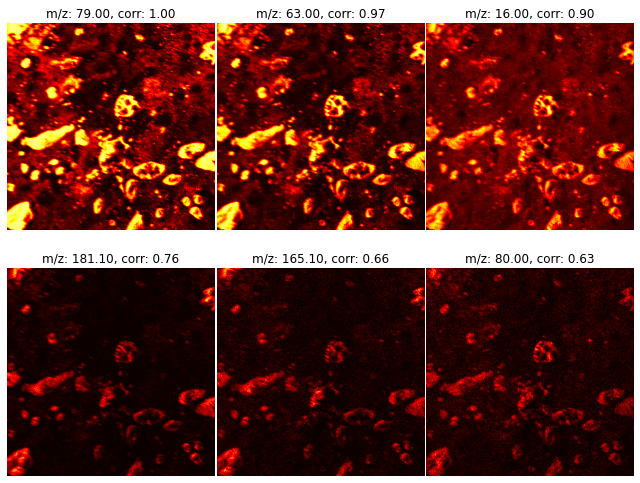

Sample_2


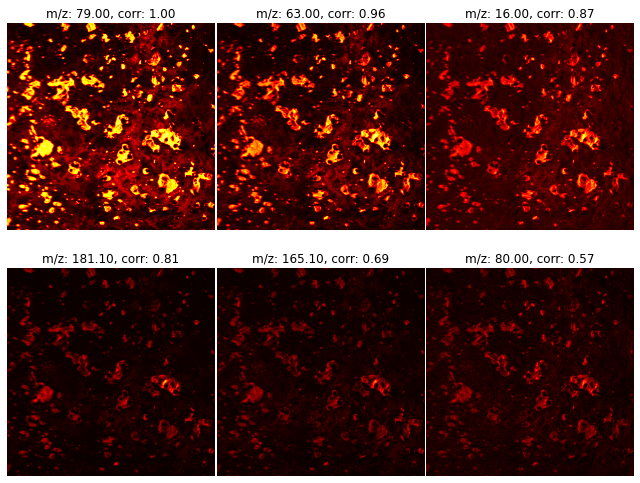

In [12]:
for dataset in datasets:
    # Read images and get PO3 channel
    print(dataset)
    imgs, labels = get_imgs(experiment, dataset)
    img_po3 = get_imgs_index(imgs, [32])
    top_similar, corrs = get_corr(imgs, img_po3)  # Get correlation

#     # Read images and get PO3 channel
#     imgs_auto, labels_auto = get_imgs(experiment, 'auto_' + dataset)
#     top_similar_auto, corrs_auto = get_corr(imgs_auto, img_po3)

    path = figure_dir / 'corr' / f'{dataset}.png'
#     plot_top_similar_combined(top_similar, imgs, masses, corrs, top_similar_auto, imgs_auto, labels_auto, corrs_auto, path=path)
    plot_top_similar(top_similar, imgs, masses, corrs)

# Plot nuclei channels

In [ ]:
for dataset in datasets:
    # Read images and get PO3 channel
    print(dataset)
    imgs, labels = get_imgs(experiment, dataset)
    img_po3 = get_imgs_index(imgs, [18, 32, 55])
    path = figure_dir / 'corr' / f'nuclei_{dataset}.png'
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(img_po3, cmap='hot')
    ax.axis('off')
    fig.savefig(path, bbox_inches='tight', transparent=True, pad_inches=0, dpi=150)
            